# Let's now look at an implementation of a neuron

In [923]:
import random
from graphviz import Digraph
import math

# Reusing the draw function from the previous notebook
def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # Left to right graph
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')  # added grad to the node 

    if n._op: # will work for non empty _op for every node, e.g for e, d, L 
      dot.node(name=uid + n._op, label= n._op ) # creating a node for the operation
      dot.edge(uid + n._op, uid) # connecting the operation (oval) node to the Value [rectangle] node

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op) # connecting the parent to the child with the operation, if there is any

  return dot


# Reusing the value class from the previous notebook, plus some extra methods and checks
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda: None
    self._len_expression_graph = 1
  def __repr__(self):
    return f"Value (data = {self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self.__add__(other)
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __rsub__(self, other):
    return Value(other) - self


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self.__mul__(other)  

  def __truediv__(self, other): # self / other
    return self * other ** -1 # (self) * (other^-1) precendence is set automatically
  
  def __rtruediv__(self, other): # other / self
    return Value(other) * self ** -1

  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float for now"
    out = Value(self.data ** other, (self,), f'**{other}')
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
      # other.grad += self.data ** other * math.log(self.data) * out.grad
    out._backward = _backward
    return out

  def exp(self):
      x = self.data
      out = Value(math.exp(x), (self,), 'exp')
      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward
      return out

  def tanh(self):
    out = Value(math.tanh(self.data), (self,), 'tanh')
    def _backward(): 
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1
    for node in reversed(topo):
      node._backward()
    self._len_expression_graph = len(topo)

  def reset_grad(self):
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        v.grad = 0.0
    build_topo(self)


## Again let's look at the diagram of a mathematical neuron object

![neuron](./img/neuron.jpeg)

### The task of a single neuron is to do multiply and accumulate. In other words, it's doing a vector dot product between two vectors. One is the input $x$ and the other is the weights $w$. Then it passes that through an activation function $(\sigma)$ to introduce non linearity.

In other words, if we consider a neuron to be a function $f(x)$, $$f(x) = \sigma(<w|x> + b)= \sigma(\sum_{i}^{n}w_i\cdot x_i + b)$$


Let's now look at it in action

In [924]:
class Neuron:

  def __init__ (self, nin): # nin is the number of inputs to the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = act.tanh()
    return out
  
x = [2.0, 5.0]
n = Neuron(2)
n(x)

Value (data = -0.9999851078292815)

### Great. Now we want to build a neural network. 

A neural network is an example of an $n-\text{partite}$ graph. Neurons are connected to each other in layers. And no two neurons from the same layer have a connection between them. Generally all the neurons from one level are connected to all the other neurons in the next level (though in practice we sometimes delete edges between neurons)


![neural-network](./img/neural-network.png)

## Let's now introduce a layer class which implements the collection on neurons abstraction

In [925]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # number of neurons in the layer

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
x = [3.0, 5.0]
l = Layer(2, 3)
l(x)

[Value (data = -0.9759714399535733),
 Value (data = 0.9812483691737701),
 Value (data = -0.9847353887038769)]

### Finally, let's build a multi layer perceptron using the classes defined above

In [926]:
class MLP:
  def __init__(self, nin, nouts): # list of number of neurons in each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)] # creating the layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


<div>
<img src="./img/neural_net2.jpeg" width="500"/>
</div>
<h3>Language models are statistical models which predict what text to generate based on a given seed text</h3>

In [927]:

## Implementing the above diagram in code
x = [3.0, 5.0, -2.0] # 3 inputs
n = MLP(3, [4, 4, 1]) # 3 inputs, two hidden layers with 4 neurons each, 1 output
n(x)


Value (data = 0.39842930102413593)

## The diagram of the expression graph of this whole MLP would be

In [928]:
# draw_dot(n(x)) # uncomment to see the diagram

### A real example of this architure in work

In [929]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets
ypred = [n(x) for x in xs] # predictions
ypred

[Value (data = 0.4176343392415774),
 Value (data = -0.8502455552187628),
 Value (data = 0.47749095177117024),
 Value (data = 0.30233677715514334)]

### Now we will change the weights of the neural network to make the predictions better

### Remember loss is a single number which measures how erroneous was our prediction. Thus this has now become an optimisation problem where we want to minimuze the loss

$\text{square error loss, }L = (y_{\text{ground truth}} - y_{\text{predicted}})^2$ is the (ignoring the sign) the error between our prediction and the ground truth

$$\text{Mean square error loss, MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{\text{gt,i}} - y_{\text{out,i}})^2$$

In [930]:
[(ygt - yout)**2 for ygt, yout in zip(ys, ypred)] # squared error

[Value (data = 0.3391497628305942),
 Value (data = 0.02242639373173663),
 Value (data = 2.182979512565679),
 Value (data = 0.4867339725102722)]

In [931]:
loss = sum ([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])/len(ys) # total loss, mean squared error
print(loss)

Value (data = 0.7578224104095705)


In [932]:
n.layers[0].neurons[0].w[0].grad

0

# What about the loss

In [933]:
loss.backward()

In [934]:
n.layers[0].neurons[0].w[0].data

-0.46587069655085633

### Because this gradient has a negative value, the influence of this particular weight of this particular neuron is also negative. I.e slightly increasing the weight of this neuron will make the loss go down

In [935]:
#draw_dot(loss) # uncomment to see the diagram

## Important thing to note here is the input layer gradients are not useful to us. The inputs to the network are given. They are not changing. We are only interested in changing the gradients of the weigts and biases of the network

### Now we want some method to gather up all the parameters of the network that we want to nudge thus we modify the classes once again

In [936]:
class Neuron:

  def __init__ (self, nin): 
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] 
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = act.tanh()
    return out
  
  def parameters(self): # pytorch also has a similar method to get the parameters
    return self.w + [self.b] # weights itself is a list of Value objects, so we can concatenate them with a listified bias
  

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # number of neurons in the layer

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):

    return [p for n in self.neurons for p in n.parameters()] # flattening the list of parameters from all neurons in the layer
    # Does the same as the following commented code
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:
  def __init__(self, nin, nouts): # list of number of neurons in each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)] # creating the layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

### Reinitialize the network

In [937]:
n = MLP(3, [4, 4, 1]) # 3 inputs, two hidden layers with 4 neurons each, 1 output
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets
ypred = [n(x) for x in xs] # predictions
ypred

[Value (data = -0.9485006099466228),
 Value (data = -0.8123337543222134),
 Value (data = -0.9864917475756863),
 Value (data = -0.3004470981945961)]

In [938]:
n.parameters()

[Value (data = 0.4330200364639387),
 Value (data = -0.466132136019062),
 Value (data = 0.8953608600217835),
 Value (data = -0.9711660178268937),
 Value (data = 0.8184352382762274),
 Value (data = 0.43225215339177003),
 Value (data = -0.545216888918822),
 Value (data = 0.4259463587508736),
 Value (data = 0.9826778966893843),
 Value (data = -0.682985747957535),
 Value (data = -0.40793041324361834),
 Value (data = -0.15298115106453447),
 Value (data = -0.1934800000499559),
 Value (data = -0.723656900372736),
 Value (data = -0.9181094535133341),
 Value (data = 0.5530171989199488),
 Value (data = -0.1746434053795034),
 Value (data = -0.246030388828121),
 Value (data = -0.8190481697780183),
 Value (data = 0.19062057359985363),
 Value (data = 0.1449190342473674),
 Value (data = 0.8889873827209906),
 Value (data = 0.8233622841523025),
 Value (data = -0.9007436193409335),
 Value (data = -0.7875982123604954),
 Value (data = 0.08398595138635234),
 Value (data = -0.0712979547593302),
 Value (data 

In [939]:
len(n.parameters())

41

In [940]:
loss = sum ([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])/len(ys) # total loss, mean squared error
print(loss)
loss.backward()

Value (data = 1.380804593703865)


Now let's slightly change the parameters according to the gradient information

In [941]:
n.layers[0].neurons[0].w[0].data

0.4330200364639387

In [942]:
# nudging the parameters in the negative gradient direction
for p in n.parameters():
  p.data += -0.01 * p.grad

In [943]:
n.layers[0].neurons[0].w[0].data

0.43297145826957273

Now let us recalculate the loss and see the change

In [944]:
print(f"Old loss: {loss.data}")
ypred = [n(x) for x in xs]
loss = sum ([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])/len(ys) # total loss, mean squared error
print(f"New loss: {loss.data}")

Old loss: 1.380804593703865
New loss: 1.3419742819043305


### Cool. We can see that we have to do few things in order to reduce the loss
1. Forward pass
2. Backward pass
3. Update

In [945]:
# Training loop
loss_history = []
for k in range (100):
  # forward pass
  ypred = [n(x) for x in xs]
  # calculate the loss
  loss = sum ([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])/len(ys) # total loss, mean squared error
  # backward pass
  # reset the gradients
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  # update the parameters
  for p in n.parameters():
    p.data += -0.1 * p.grad
  # store the loss for plotting
  loss_history.append((k+1, loss.data))

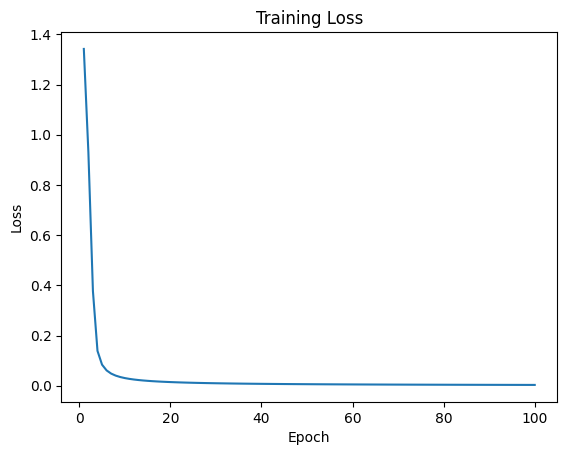

In [946]:
import matplotlib.pyplot as plt
plt.plot([x for x, _ in loss_history], [y for _, y in loss_history])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [947]:
for ygt,yout in zip(ys, ypred):
  print(f"Actual value:{ygt} \t Predicted Value:{yout}")

Actual value:1.0 	 Predicted Value:Value (data = 0.9389416640059781)
Actual value:-1.0 	 Predicted Value:Value (data = -0.9274730349302557)
Actual value:-1.0 	 Predicted Value:Value (data = -0.9719050781838812)
Actual value:1.0 	 Predicted Value:Value (data = 0.9471260257953438)
